# **Dataset Preparation for Latin-English Translation and Summarization**

This notebook focuses on three main tasks:

1. **Extractive Summarization for mT5 Pretraining**: Generating extractive summaries from Latin texts and evaluating them with a fine-tuned Mistral model.
2. **Dataset Cleaning and POS Tagging for Translation**: Preparing a clean dataset for English-Latin translation and performing linguistic analysis using Stanza.
3. **Prompt Generation and Train-Test Splitting**: Creating structured prompts for translation and summarization tasks and organizing datasets for model training.

---

## **Table of Contents**

### 1. Extractive Summarization for mT5 Pretraining
- 1.1 **Load Libraries**
- 1.2 **Define Global Parameters**
- 1.3 **Load and Sample Dataset**
- 1.4 **Generate Extractive Summaries**
- 1.5 **Evaluate Summaries with Mistral Model**
- 1.6 **Save Processed Data (Optional)**
- 1.7 **Analyze Summary Quality (Grading and Statistics)**

### 2. Dataset Cleaning and POS Tagging for Translation
- 2.1 **Load Libraries**
- 2.2 **Define Global Parameters**
- 2.3 **Clean and Preprocess English-Latin Dataset**
- 2.4 **Save Cleaned Dataset**
- 2.5 **Perform POS Tagging with Stanza**
- 2.6 **Analyze XPOS Tags Across Languages**
- 2.7 **Save POS-Tagged Dataset**

### 3. Prompt Generation and Train-Test Splitting
- 3.1 **Generate Translation Prompts (With and Without Stanza)**
- 3.2 **Generate Summarization Prompts**
- 3.3 **Prepare Special Tokens for Training**
- 3.4 **Train-Test Split for Model Training**
- 3.5 **Save Final Processed Datasets**

---

## Extractive Summarization for mT5 Pretraining

#### Divide the dataset into chunks of the same length

In [ ]:
import pandas as pd
from utils.split_chunks import split_into_chunks

In [ ]:
path_to_data = '/Data/AxelDlv/LatinSummarizer/latin-literature-dataset-170M_raw_cleaned.csv' 
output_path = '/Data/AxelDlv/LatinSummarizer/latin-literature-dataset-170M_raw_cleaned_chunked.csv'
chunk_size = 400

In [ ]:
try:
    df = pd.read_csv(path_to_data)
except FileNotFoundError:
    print('File not found')
    
df

In [19]:
# Create a new DataFrame with chunked texts
new_data = []

for index, row in df.iterrows():
    text_chunks = split_into_chunks(row["text"], chunk_size=chunk_size) # Split the text into chunks of size `chunk_size` words
    for chunk_index, chunk in enumerate(text_chunks):
        new_data.append({
            "original_index": index,  # Keep track of the original row
            "chunk_index": chunk_index,  # Index within the split text
            "text_chunk": chunk,
            "word_count": len(chunk.split())  # Store the word count for verification
        })

# Convert to DataFrame
df_chunks = pd.DataFrame(new_data)

df_chunks

,original_index,chunk_index,text_chunk,word_count
0,0,0,De facto Ungarie magne a fratre Riccardo inven...,382
1,0,1,Deus autem dedit ipsis gratiam in conspectu do...,396
2,0,2,3 Tandem ipsi habita quorundam paganorum socie...,364
3,0,3,Qui eo viso et quod esset Ungarus christianus ...,398
4,0,4,In redeundo de predicta Ungaria transivit in f...,387
...,...,...,...,...
1156570,7797,4,"Si quis aut episcopus, aut praelatus quislibet...",393
1156571,7797,5,Ego Stephanus sanctae Romanae Ecclesiae cardin...,33
1156572,7798,0,Epistola ad W. coepiscopum #Consultus a Widone...,332
1156573,7798,1,"Hoc est excerptum de sexto libro Capitularium,...",395


In [23]:
# Remove columns where the word count is less than 0.75 * chunk_size
df_chunks = df_chunks[df_chunks["word_count"] >= 0.9 * chunk_size]
df_chunks

,original_index,chunk_index,text_chunk,word_count
0,0,0,De facto Ungarie magne a fratre Riccardo inven...,382
1,0,1,Deus autem dedit ipsis gratiam in conspectu do...,396
2,0,2,3 Tandem ipsi habita quorundam paganorum socie...,364
3,0,3,Qui eo viso et quod esset Ungarus christianus ...,398
4,0,4,In redeundo de predicta Ungaria transivit in f...,387
...,...,...,...,...
1156567,7797,1,Quicunque vero aliquid ad jus Ecclesiae pertin...,394
1156568,7797,2,#Ut nullus episcopus beneficium vendat aut det...,400
1156569,7797,3,"Quod si fecerit, et vendens, et emens, ea care...",384
1156570,7797,4,"Si quis aut episcopus, aut praelatus quislibet...",393


In [24]:
# Save the new DataFrame
df_chunks.to_csv(output_path, index=False)

#### Packages

In [1]:
from utils.extractive_summary import extractive_summary, pretty_print_summary
from utils.grade_extractive_summary import evaluate_summary, load_model, convert_output_to_grade
import pandas as pd
import torch
from tqdm import tqdm
tqdm.pandas()

[nltk_data] Downloading package punkt to
[nltk_data]     /users/eleves-b/2022/axel.delaval/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/Data/AxelDlv/condaenvs/mistral_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     /users/eleves-b/2022/axel.delaval/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#### Global variables

In [7]:
path_to_data = '/Data/AxelDlv/LatinSummarizer/latin-literature-dataset-170M_raw_cleaned_chunked.csv'
output_path = '/Data/AxelDlv/LatinSummarizer/latin-literature-dataset-170M_raw_cleaned_chunked_summaries.csv' 

MODEL_PATH="/Data/AxelDlv/mt5-small-en-la-translation_hf/Mistral-7B-Instruct-v0.3/",
tokenizer_name="tokenizer.model.v3",
DOWNLOAD_MODEL=False

#### Prepare DataFrame

In [3]:
try:
    df = pd.read_csv(path_to_data)
except FileNotFoundError:
    df = pd.DataFrame()
    df['text'] = ['Franciscus I Stephanus Res apud repertae: Franciscus I Stephanus Habsburgi-Lotharingiae (natus Nanceii die 8 Decembris 1708 - obiit Aeniponti die 18 Augusti 1765) fuit ab anno 1729 usque ad annum 1737 dux Lotharingiae, postea usque ad mortem magnus dux Tusciae ac a die 4 Octobris 1745, quo die Francofurti coronatus est, imperator Sacri Romani Imperii. Die 12 Februarii 1736 Franciscus Mariam Theresiam Habsburgum in matrimonium duxit. Eques fuit Ordinis Aurei Velleris. Vita. Filius ducis Leopoldi Iosephi Caroli Lotharingiensis et principissae Elisae Carolotta Aureliaca inde ab anno 1723 Vindobonae est educatus. Ducatum Silesiensis Teschenensem recepit et ab anno 1729 imperium in Lotharingia nactus est. Ob pacem inter Austriam et Francogallicam factam ad terminandum Bellum de successione Polonica anno 1735 terras suas Ludovici XV socero Stanislao I tradidit. Recompensationi ei data est spes imperii de Magno Ducatu Tusciae qui revera 1737 in manus Austriacas venit. A die 12 Februarii 1736 maritus fuit Mariae Theresiae, filiae imperatoris Caroli VI. Franciscus Stephanus die 11 Aprilis 1736 documentum concessorium subsignans recepit non solum potestatem administratoriam in Nederlandia sed etiam promissionem matrimonii inter Mariannam imperatoris filiam alteram et eius fratrem Carolum faciendi. Carolo VI vita defuncto uxor Maria Theresia eum collegam gubernantem declaravit, attamen ille directo nihil imperabat. Mortuo Carolo VII denique ipse imperator factus est; coronatio celebrata est die 20 Ianuarii 1745 Francofurti. Politicam totam autem in manibus uxoris sinivit, cum ipse scientias artes commercialia in Austria augeri operam fertilissimam daret. Filii eius quoque partes politicas maiores agebant: Iosephus et Leopoldus imperatores facti sunt, Ferdinandus dux Mutinensis, Maximilianus declaratus est "Hoch-und Deutschmeister". Natae quattuor quoque mentionis publicae dignae sunt: Carolina factus est Neapolitana regina, Amalia ducissa Chrisopolitana et Maria Antonia regina Franciae. Bibliographia. Romanorum Imperatores et reges']
    print('PLEASE PROVIDE A CSV FILE WITH A COLUMN NAMED "text"')
    print('Using a default text for testing purposes')
df

,original_index,chunk_index,text_chunk,word_count
0,0,0,De facto Ungarie magne a fratre Riccardo inven...,382
1,0,1,Deus autem dedit ipsis gratiam in conspectu do...,396
2,0,2,3 Tandem ipsi habita quorundam paganorum socie...,364
3,0,3,Qui eo viso et quod esset Ungarus christianus ...,398
4,0,4,In redeundo de predicta Ungaria transivit in f...,387
...,...,...,...,...
1061570,7797,1,Quicunque vero aliquid ad jus Ecclesiae pertin...,394
1061571,7797,2,#Ut nullus episcopus beneficium vendat aut det...,400
1061572,7797,3,"Quod si fecerit, et vendens, et emens, ea care...",384
1061573,7797,4,"Si quis aut episcopus, aut praelatus quislibet...",393


#### Create the extractive summaries

In [4]:
df['extractive_summary'] = df['text_chunk'].progress_apply(extractive_summary)
print('Example :')
i = df.index[0]
pretty_print_summary(df['text_chunk'][i], df['extractive_summary'][i])
df

100%|██████████| 1061575/1061575 [1:10:01<00:00, 252.65it/s]

Example :

----------------------------------------------------------------------------------------------------
                                           ORIGINAL TEXT
----------------------------------------------------------------------------------------------------
De facto Ungarie magne a fratre Riccardo invento tempore domini Gregorii Rico, pape noni. CAP. 1
Inventum fuit in gestis Ungarorum Christianorum, quod esset alia Ungaria maior, de qua Septem duces
cum populis suis egressi fuerant, ut habitandi quererent sibi locum, eo quod terra ipsorum
multitudinem inhabitantium sustinere non posset. Qui cum multa regna pertransissent et
destruxissent, tandem venerunt in terram, que nunc Ungaria dicitur, tunc vero dicebatur pascua
Romanorum. Quam ad inhabitandum pre terris ceteris elegerunt subiectis sibi populis, qui tunc
habitabant ibidem. Ubi tandem per sanctum Stephanum primum ipsorum regem ad fidem catholicam sunt
reversi, prioribus Ungaris, a quibus isti descenderant, in infidelit

,original_index,chunk_index,text_chunk,word_count,extractive_summary
0,0,0,De facto Ungarie magne a fratre Riccardo inven...,382,De facto Ungarie magne a fratre Riccardo inven...
1,0,1,Deus autem dedit ipsis gratiam in conspectu do...,396,Deus autem dedit ipsis gratiam in conspectu do...
2,0,2,3 Tandem ipsi habita quorundam paganorum socie...,364,3 Tandem ipsi habita quorundam paganorum socie...
3,0,3,Qui eo viso et quod esset Ungarus christianus ...,398,Qui eo viso et quod esset Ungarus christianus ...
4,0,4,In redeundo de predicta Ungaria transivit in f...,387,In redeundo de predicta Ungaria transivit in f...
...,...,...,...,...,...
1061570,7797,1,Quicunque vero aliquid ad jus Ecclesiae pertin...,394,Quicunque vero aliquid ad jus Ecclesiae pertin...
1061571,7797,2,#Ut nullus episcopus beneficium vendat aut det...,400,#Ut nullus episcopus beneficium vendat aut det...
1061572,7797,3,"Quod si fecerit, et vendens, et emens, ea care...",384,"Quod si fecerit, et vendens, et emens, ea care..."
1061573,7797,4,"Si quis aut episcopus, aut praelatus quislibet...",393,"Si quis aut episcopus, aut praelatus quislibet..."


In [5]:
# Save the new DataFrame
df.to_csv(output_path, index=False)

#### Rate the summaries with mistral

In [12]:
from utils.extractive_summary import extractive_summary, pretty_print_summary
from utils.grade_extractive_summary import evaluate_summary, load_model, convert_output_to_grade
import pandas as pd
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
tqdm.pandas()

In [2]:
input_path = '/Data/AxelDlv/LatinSummarizer/latin-literature-dataset-170M_raw_cleaned_chunked_summaries.csv' 
output_path = '/Data/AxelDlv/LatinSummarizer/latin-literature-dataset-170M_raw_cleaned_chunked_summaries_graded.csv'

MODEL_PATH="/Data/AxelDlv/mt5-small-en-la-translation/Mistral-7B-Instruct-v0.3/"
tokenizer_name="tokenizer.model.v3"
DOWNLOAD_MODEL=False

In [3]:
df = pd.read_csv(input_path)
df

,original_index,chunk_index,text_chunk,word_count,extractive_summary
0,0,0,De facto Ungarie magne a fratre Riccardo inven...,382,De facto Ungarie magne a fratre Riccardo inven...
1,0,1,Deus autem dedit ipsis gratiam in conspectu do...,396,Deus autem dedit ipsis gratiam in conspectu do...
2,0,2,3 Tandem ipsi habita quorundam paganorum socie...,364,3 Tandem ipsi habita quorundam paganorum socie...
3,0,3,Qui eo viso et quod esset Ungarus christianus ...,398,Qui eo viso et quod esset Ungarus christianus ...
4,0,4,In redeundo de predicta Ungaria transivit in f...,387,In redeundo de predicta Ungaria transivit in f...
...,...,...,...,...,...
1061570,7797,1,Quicunque vero aliquid ad jus Ecclesiae pertin...,394,Quicunque vero aliquid ad jus Ecclesiae pertin...
1061571,7797,2,#Ut nullus episcopus beneficium vendat aut det...,400,#Ut nullus episcopus beneficium vendat aut det...
1061572,7797,3,"Quod si fecerit, et vendens, et emens, ea care...",384,"Quod si fecerit, et vendens, et emens, ea care..."
1061573,7797,4,"Si quis aut episcopus, aut praelatus quislibet...",393,"Si quis aut episcopus, aut praelatus quislibet..."


In [4]:
model, tokenizer = load_model(MODEL_PATH=MODEL_PATH, tokenizer_name=tokenizer_name, DOWNLOAD_MODEL=DOWNLOAD_MODEL)

In [5]:
df = df.sample(5000)

In [6]:
df['grade'] = df.progress_apply(lambda x: evaluate_summary(x['text_chunk'], x['extractive_summary'], model, tokenizer, n_tokens=10), axis=1)
df['grade'] = df['grade'].apply(lambda x: convert_output_to_grade(x))
df

100%|██████████| 5000/5000 [3:26:35<00:00,  2.48s/it]  


,original_index,chunk_index,text_chunk,word_count,extractive_summary,grade
590054,3124,353,LP egt rebellem aduersus Christom Christum et ...,375,LP egt rebellem aduersus Christom Christum et ...,35.0
534840,2790,8530,Ea res occasionem mihi praebuit colligendi qua...,391,Ea res occasionem mihi praebuit colligendi qua...,49.0
72228,893,265,Ad haec inquam: Nec ista Scripturae testimonia...,394,Ad haec inquam: Nec ista Scripturae testimonia...,49.0
48437,751,336,Relatum enim est mihi quosdam e fratribus adve...,386,Relatum enim est mihi quosdam e fratribus adve...,42.0
523389,2785,329,Carmina iure fero: quia cultu carmine facto Vi...,397,Carmina iure fero: quia cultu carmine facto Vi...,71.0
...,...,...,...,...,...,...
388284,2204,1562,"Carminius tamen dicit, qui de elocutionibus sc...",396,"Carminius tamen dicit, qui de elocutionibus sc...",47.0
358252,2053,163,Praestat enim principium dare rei quae exitum ...,397,Praestat enim principium dare rei quae exitum ...,67.0
708162,4299,3,"Hec sub luxurie vicio predicta tenentur, Que n...",381,"Hec sub luxurie vicio predicta tenentur, Que n...",42.0
920834,6006,29,#De his quos parentes ab infantia clericatus o...,363,#De his quos parentes ab infantia clericatus o...,85.0


In [7]:
# free cache and model 
del model
del tokenizer
torch.cuda.empty_cache()

In [9]:
if output_path:
    df.to_csv(output_path, index=False)

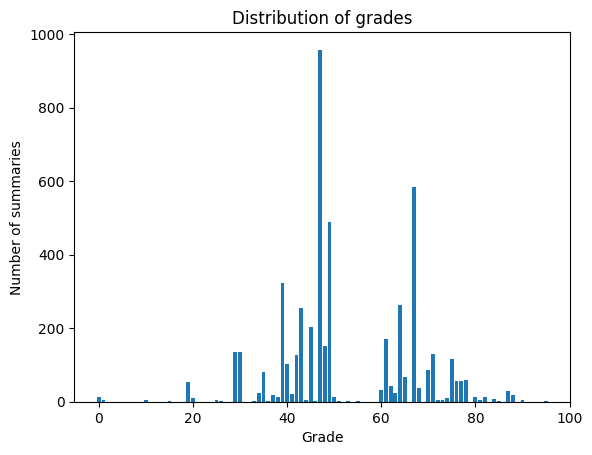

In [14]:
# Plot an histogram of the grades
GRADES = df['grade'].value_counts().sort_index()
plt.bar(GRADES.index, GRADES.values)
plt.xlabel('Grade')
plt.ylabel('Number of summaries')
plt.title('Distribution of grades')
plt.show()



In [15]:
# Print statistics on the grades
print('Statistics on the grades:')
print('Mean grade:', df['grade'].mean())
print('Median grade:', df['grade'].median())
print('Standard deviation:', df['grade'].std())
print('Minimum grade:', df['grade'].min())
print('Maximum grade:', df['grade'].max())

Statistics on the grades:
Mean grade: 52.1648
Median grade: 47.0
Standard deviation: 14.361033696004043
Minimum grade: 0.0
Maximum grade: 95.0


## Prepare translation dataset

### Clean Data

#### Packages

In [1]:
from utils.clean_dataframe import clean_up_df
import pandas as pd

#### Global variables

In [2]:
path_to_data = '/Data/AxelDlv/LatinSummarizer/latin-literature-dataset-170M/latin_raw.csv' # Expects a csv file with a column named 'text' with the text to summarize in latin
output_path = '/Data/AxelDlv/LatinSummarizer/latin-literature-dataset-170M_raw_cleaned.csv' # Path to save the output csv file with the summaries, if '' it will not save the output

columns_to_clean = ["text"]

#### Prepare the dataframe

In [3]:
try:
    df = pd.read_csv(path_to_data)
except FileNotFoundError:
    df = pd.DataFrame()
    df['la'] = ['Franciscus I Stephanus Res apud repertae: Franciscus I Stephanus Habsburgi-Lotharingiae (natus Nanceii die 8 Decembris 1708 - obiit Aeniponti die 18 Augusti 1765) fuit ab anno 1729 usque ad annum 1737 dux Lotharingiae, postea usque ad mortem magnus dux Tusciae ac a die 4 Octobris 1745, quo die Francofurti coronatus est, imperator Sacri Romani Imperii. Die 12 Februarii 1736 Franciscus Mariam Theresiam Habsburgum in matrimonium duxit. Eques fuit Ordinis Aurei Velleris. Vita. Filius ducis Leopoldi Iosephi Caroli Lotharingiensis et principissae Elisae Carolotta Aureliaca inde ab anno 1723 Vindobonae est educatus. Ducatum Silesiensis Teschenensem recepit et ab anno 1729 imperium in Lotharingia nactus est. Ob pacem inter Austriam et Francogallicam factam ad terminandum Bellum de successione Polonica anno 1735 terras suas Ludovici XV socero Stanislao I tradidit. Recompensationi ei data est spes imperii de Magno Ducatu Tusciae qui revera 1737 in manus Austriacas venit. A die 12 Februarii 1736 maritus fuit Mariae Theresiae, filiae imperatoris Caroli VI. Franciscus Stephanus die 11 Aprilis 1736 documentum concessorium subsignans recepit non solum potestatem administratoriam in Nederlandia sed etiam promissionem matrimonii inter Mariannam imperatoris filiam alteram et eius fratrem Carolum faciendi. Carolo VI vita defuncto uxor Maria Theresia eum collegam gubernantem declaravit, attamen ille directo nihil imperabat. Mortuo Carolo VII denique ipse imperator factus est; coronatio celebrata est die 20 Ianuarii 1745 Francofurti. Politicam totam autem in manibus uxoris sinivit, cum ipse scientias artes commercialia in Austria augeri operam fertilissimam daret. Filii eius quoque partes politicas maiores agebant: Iosephus et Leopoldus imperatores facti sunt, Ferdinandus dux Mutinensis, Maximilianus declaratus est "Hoch-und Deutschmeister". Natae quattuor quoque mentionis publicae dignae sunt: Carolina factus est Neapolitana regina, Amalia ducissa Chrisopolitana et Maria Antonia regina Franciae. Bibliographia. Romanorum Imperatores et reges'],
    df['en'] = ['Fantastic Beasts: The Secrets of Dumbledore is an upcoming fantasy film directed by David Yates and written by J.K. Rowling and Steve Kloves. It is a sequel to Fantastic Beasts: The Crimes of Grindelwald (2018) and the third instalment in the Fantastic Beasts series. The film stars Eddie Redmayne, Jude Law, Mads Mikkelsen, Ezra Miller, Alison Sudol, Callum Turner, Jessica Williams, and Dan Fogler. The film is set to be released on April 15, 2022, by Warner Bros. Pictures.']
    print('Using a default df for testing purposes')
df

,Unnamed: 0,title,text,author,year
0,latin_xmls\10.xml,De facto Ungarie magne1236\n,\n\nDe facto Ungarie magne\n\na fratre Riccard...,Riccardus OFM,fl.1236
1,latin_xmls\100.xml,De trinitate,\n\n ARGUMENTUM.\n\n\n #Dividitur tract...,Novatianus,fl. 260
2,latin_xmls\10000.xml,De quadratura circuli,\n\n\n NOTA.\nDiximus falso videri Be...,Franco Leodiensis,NaN
3,latin_xmls\10001.xml,Epistola ad Berengarium,\n\n Epistola ad Berengarium\n\nDomino ...,Frollandus Sylvanectensis,NaN
4,latin_xmls\10002.xml,Diplomata,\n\n I. #Charta fundationis seu restitu...,Gervasius Remensis1055-1067,1055-1067
...,...,...,...,...,...
7814,latin_xmls\9995.xml,Vita Hermanni,"\n\n Vita Hermanni\n\nHermannus, qui et...",Bertholdus Augiae Divitis,1030-1088
7815,latin_xmls\9996.xml,Diplomata,"\n\n I. #Bruno, episcopus Tullensis abb...",Bruno Tullensis,NaN
7816,latin_xmls\9997.xml,Notitia de instauratione coenobii S. Apri,\n\n Notitia de instauratione coenobii ...,Bruno Tullensis,NaN
7817,latin_xmls\9998.xml,Acta,\n\n TITULI CAPITULORUM.\n\n\n\n VIII. ...,Concilium Turonense,fl. 567


In [4]:
df = clean_up_df(df, columns=columns_to_clean, verbose=True)
df

Initial dataset shape: (7819, 5)

--------------------------------------------------
 - Statistics for column 'text':
    - Mean: 60133.06
    - Std: 231865.86
    - Min: 26
    - Max: 6545497
--------------------------------------------------

Removed 0 rows with NaN values.
Removed 5 rows with unwanted patterns.
Removed 0 duplicate rows.
Removed 14 rows with identical values in all columns.
Removed 1 rows without Roman letters.
--------------------------------------------------
 - Statistics for column 'text':
    - Mean: 56802.40
    - Std: 225328.53
    - Min: 24
    - Max: 6545441
--------------------------------------------------



,Unnamed: 0,title,text,author,year
0,latin_xmls\10.xml,De facto Ungarie magne1236\n,De facto Ungarie magne\n\na fratre Riccardo in...,Riccardus OFM,fl.1236
1,latin_xmls\100.xml,De trinitate,ARGUMENTUM.\n\n\n #Dividitur tractatus Novatia...,Novatianus,fl. 260
2,latin_xmls\10000.xml,De quadratura circuli,NOTA.\nDiximus falso videri Bertium referre ad...,Franco Leodiensis,NaN
3,latin_xmls\10001.xml,Epistola ad Berengarium,Epistola ad Berengarium\n\nDomino et fratri BE...,Frollandus Sylvanectensis,NaN
4,latin_xmls\10002.xml,Diplomata,I. #Charta fundationis seu restitutionis duode...,Gervasius Remensis1055-1067,1055-1067
...,...,...,...,...,...
7814,latin_xmls\9995.xml,Vita Hermanni,"Vita Hermanni\n\nHermannus, qui et heros magnu...",Bertholdus Augiae Divitis,1030-1088
7815,latin_xmls\9996.xml,Diplomata,"I. #Bruno, episcopus Tullensis abbatiae Sancti...",Bruno Tullensis,NaN
7816,latin_xmls\9997.xml,Notitia de instauratione coenobii S. Apri,Notitia de instauratione coenobii S. Apri\n\nI...,Bruno Tullensis,NaN
7817,latin_xmls\9998.xml,Acta,TITULI CAPITULORUM.\n\n\n\n VIII. #De laicis q...,Concilium Turonense,fl. 567


In [5]:
# Save the cleaned dataframe
if output_path:
    df.to_csv(output_path, index=False)

### Compute Stanza informations

#### Packages

In [12]:
import stanza
import pandas as pd
from tqdm import tqdm

#### Global variables

In [13]:
input_path = '/Data/AxelDlv/LatinSummarizer/Elsa_aligned_cleaned.csv'
output_path = '/Data/AxelDlv/LatinSummarizer/Elsa_aligned_cleaned_with_stanza.parquet'

# Define languages
language1 = 'en'
language2 = 'la'

# Load Stanza pipelines
nlp_1 = stanza.Pipeline(lang=language1, processors="tokenize,pos", use_gpu=True, verbose=False, batch_size=128, use_fast=True)
nlp_2 = stanza.Pipeline(lang=language2, processors="tokenize,pos", use_gpu=True, verbose=False, batch_size=128, use_fast=True)

# Extract XPOS vocabularies
xpos_vocab1 = nlp_1.processors["pos"].vocab["xpos"]
xpos_vocab2 = nlp_2.processors["pos"].vocab["xpos"]

# Extract XPOS tags for English (WordVocab)
xpos_tags1 = sorted(set(xpos_vocab1._id2unit))  # Directly use the keys from _id2unit

# Extract XPOS tags for Latin (XPOSVocab)
xpos_tags2 = sorted(set(tag for group in xpos_vocab2._id2unit.values() 
                         for tag in (group if isinstance(group, list) else [group])))

# Compare the tag sets
print(f"xpos_tags_{language1} and xpos_tags_{language2} are the same" if xpos_tags1 == xpos_tags2 
      else f"xpos_tags_{language1} and xpos_tags_{language2} are different")

print(f"Number of xpos_tag_{language1}:", len(xpos_tags1))
print(f"Number of xpos_tag_{language2}:", len(xpos_tags2))

# Merge and sort unique XPOS tags from both languages
xpos_tags = sorted(set(xpos_tags1 + xpos_tags2))

print(f"Total number of XPOS tags: {len(xpos_tags)}")
print(f"XPOS tags: {xpos_tags}")

xpos_tags_en and xpos_tags_la are different
Number of xpos_tag_en: 53
Number of xpos_tag_la: 104
Total number of XPOS tags: 153
XPOS tags: ['$', "''", ',', '-', '-LRB-', '-RRB-', '.', '04', '5', ':', '<EMPTY>', '<PAD>', '<ROOT>', '<UNK>', 'A1', 'ADD', 'AFX', 'B1', 'B2', 'B5', 'C1', 'CC', 'CD', 'D1', 'DT', 'E1', 'EX', 'F1', 'FW', 'G1', 'G5', 'GW', 'HYPH', 'IN', 'J1', 'J2', 'J3', 'JJ', 'JJR', 'JJS', 'K2', 'K3', 'L2', 'L3', 'LS', 'M2', 'M3', 'MD', 'N2', 'N3', 'NFP', 'NN', 'NNP', 'NNPS', 'NNS', 'O4', 'PDT', 'POS', 'PRP', 'PRP$', 'Punc', 'RB', 'RBR', 'RBS', 'RP', 'S4', 'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB', '``', 'cas0', 'cas1', 'cas2', 'cas3', 'cas5', 'cas6', 'cas9', 'casA', 'casB', 'casC', 'casD', 'casE', 'casF', 'casG', 'casH', 'casJ', 'casK', 'casL', 'casM', 'casN', 'casO', 'casj', 'comC', 'comH', 'comM', 'comQ', 'comT', 'comZ', 'gen0', 'gen1', 'gen2', 'gen3', 'gen4', 'gen5', 'gen6', 'gen7', 'gen8', 'gen9', 'grn1', 'grn2', 'grn3', 'grn8', 

#### Load df

In [14]:
try: 
    df = pd.read_csv(input_path)
except FileNotFoundError:
    # Create a default dataframe for testing purposes
    df = pd.DataFrame({"text": [
    "Caesar venit, vidit, vicit.",
    "Gallia est omnis divisa in partes tres."
    ]})
df

,path,en,la
0,57,What have you given me to defend my client aga...,"quid mihi ad defendendum dedisti, bone accusat..."
1,11,We who are pleading this cause adopt the excl...,qua vociferatione in ceteris iudiciis accusato...
2,64,Still as it was plain to the judges that they ...,"tamen , cum planum iudicibus esset factum ape..."
3,146,"You know that the man has nothing, dares do no...","scis hunc nihil habere, nihil audere , nihil ..."
4,31,"Who, indeed, is of so profligate a disposition...",etenim quis tam dissoluto animo est qui haec ...
...,...,...,...
3787,65,And if I were to speak of these matters as the...,vidi ego in quodam iudicio nuper Philodor...
3788,50,"Or, as it is written in this same decree, that...","hic ego, iudices, si vos Acmonensium decr..."
3789,8,"And I wish that my enemies, and those of all g...",Vtinam esset proprie mea! senatus igitur magna...
3790,21,But all the republics of the Greeks are gover...,"de quibus vos aliis testes esse debetis, de ei..."


#### Apply stanza on the df

In [15]:
def process_text_with_stanza(df, column, nlp):
    """
    Processes a text column using Stanza NLP pipeline and extracts:
    - Tokenized words
    - UPOS (Universal POS tags)
    - XPOS (Language-specific POS tags)

    Args:
        df (pd.DataFrame): Input dataframe containing text.
        column (str): Column name to process.
        nlp (stanza.Pipeline): Pre-loaded Stanza NLP pipeline.

    Returns:
        pd.DataFrame: Updated DataFrame with additional columns:
        - {column}_tokenized
        - {column}_upos
        - {column}_xpos
    """
    tqdm.pandas()  # Enable progress bar for Pandas operations

    def stanza_process(text):
        """Apply Stanza NLP to extract tokens, UPOS, and XPOS."""
        if pd.isna(text) or text.strip() == "":
            return [], [], []  # Return empty lists for NaN or empty text

        doc = nlp(text)
        tokens, upos_tags, xpos_tags = [], [], []
        
        for sent in doc.sentences:
            for word in sent.words:
                tokens.append(word.text)
                upos_tags.append(word.upos)
                xpos_tags.append(word.xpos)
        
        return tokens, upos_tags, xpos_tags

    # Apply Stanza processing on the specified column
    results = df[column].progress_apply(stanza_process)
    
    # Extract and assign new columns
    df[f"{column}_tokenized"], df[f"{column}_upos"], df[f"{column}_xpos"] = zip(*results)
    return df


In [ ]:
df = process_text_with_stanza(df, language1, nlp_1)
df = process_text_with_stanza(df, language2, nlp_2)
df

  2%|▏         | 61/3792 [00:08<09:05,  6.84it/s]

In [ ]:
if output_path:
    df.to_parquet(output_path, index=False)

# Prepare the prompts

## Add the tags 

In [1]:
from utils.prompt_generator import generate_prompt_no_stanza, generate_prompt_with_stanza, generate_prompts_with_distribution, generate_prompt_summaries
import pandas as pd

In [2]:
input_path = '/Data/AxelDlv/LatinSummarizer/concat_aligned_with_stanza.parquet'
output_path = '/Data/AxelDlv/LatinSummarizer/concat_cleaned_with_stanza_prompts.parquet'

In [3]:
try: 
    df = pd.read_parquet(input_path)
except FileNotFoundError:
    # Create a default dataframe for testing purposes
    df = pd.DataFrame({"en": ["Caesar venit, vidit, vicit."], "la": ["Veni, vidi, vici."]})
df

,en,la,en_tokenized,en_upos,en_xpos,la_tokenized,la_upos,la_xpos
0,What have you given me to defend my client aga...,"quid mihi ad defendendum dedisti, bone accusat...","[What, have, you, given, me, to, defend, my, c...","[PRON, AUX, PRON, VERB, PRON, PART, VERB, PRON...","[WP, VBP, PRP, VBN, PRP, TO, VB, PRP$, NN, IN,...","[quid, mihi, ad, defendendum, dedisti, ,, bone...","[PRON, PRON, ADP, VERB, VERB, PUNCT, VERB, NOU...","[F1|grn1|casA|gen3, F1|grn1|casC|gen1|vgr1, S4..."
1,We who are pleading this cause adopt the excl...,qua vociferatione in ceteris iudiciis accusato...,"[We, who, are, pleading, this, cause, adopt, t...","[PRON, PRON, AUX, VERB, DET, NOUN, VERB, DET, ...","[PRP, WP, VBP, VBG, DT, NN, VB, DT, NNS, WDT, ...","[qua, vociferatione, in, ceteris, iudiciis, ac...","[PRON, NOUN, ADP, DET, NOUN, NOUN, VERB, VERB,...","[F1|grn1|casF|gen2|varA, C1|grn1|casF|gen2|com..."
2,Still as it was plain to the judges that they ...,"tamen , cum planum iudicibus esset factum ape...","[Still, as, it, was, plain, to, the, judges, t...","[ADV, SCONJ, PRON, AUX, ADJ, ADP, DET, NOUN, S...","[RB, IN, PRP, VBD, JJ, IN, DT, NNS, IN, PRP, V...","[tamen, ,, cum, planum, iudicibus, esset, fact...","[ADV, PUNCT, SCONJ, ADJ, NOUN, AUX, VERB, VERB...","[O4, Punc, S4|vgr1, B1|grn1|casA|gen3, C1|grn1..."
3,"You know that the man has nothing, dares do no...","scis hunc nihil habere, nihil audere , nihil ...","[You, know, that, the, man, has, nothing, ,, d...","[PRON, VERB, SCONJ, DET, NOUN, VERB, PRON, PUN...","[PRP, VBP, IN, DT, NN, VBZ, NN, ,, VBZ, VB, NN...","[scis, hunc, nihil, habere, ,, nihil, audere, ...","[VERB, DET, PRON, VERB, PUNCT, PRON, VERB, PUN...","[M3|modC|tem1|gen5, F1|grn1|casD|gen1, G1|casA..."
4,"Who, indeed, is of so profligate a disposition...",etenim quis tam dissoluto animo est qui haec ...,"[Who, ,, indeed, ,, is, of, so, profligate, a,...","[PRON, PUNCT, ADV, PUNCT, AUX, ADP, ADV, ADJ, ...","[WP, ,, RB, ,, VBZ, IN, RB, JJ, DT, NN, ,, IN,...","[etenim, quis, tam, dissoluto, animo, est, qui...","[SCONJ, PRON, ADV, VERB, NOUN, AUX, PRON, DET,...","[O4, F1|grn1|casA|gen1|varA, O4, L2|modM|tem4|..."
...,...,...,...,...,...,...,...,...
223427,Bid the patient refrain from eating in the eve...,Incenatum iubeto esse.,"[Bid, the, patient, refrain, from, eating, in,...","[VERB, DET, NOUN, VERB, SCONJ, VERB, ADP, DET,...","[VB, DT, NN, VB, IN, VBG, IN, DT, NN, ,]","[Incenatum, iubeto, esse, .]","[VERB, VERB, AUX, PUNCT]","[J2|modM|tem4|grp1|casA|gen3, K3|modA|tem1|gen..."
223428,"The number, I remark, is not to be taken as pr...","Sic, inquam, numerus non est ut sit ad amussim...","[The, number, ,, I, remark, ,, is, not, to, be...","[DET, NOUN, PUNCT, PRON, VERB, PUNCT, AUX, PAR...","[DT, NN, ,, PRP, VBP, ,, VBZ, RB, TO, VB, VBN,...","[Sic, ,, inquam, ,, numerus, non, est, ut, sit...","[ADV, PUNCT, VERB, PUNCT, NOUN, PART, AUX, SCO...","[O4, Punc, L3|modA|tem1|gen5, Punc, B1|grn1|ca..."
223429,By advertisement of the same cities Caesar hav...,"Iisdem demonstrantibus, Caesar oppidum Cassobe...","[By, advertisement, of, the, same, cities, Cae...","[ADP, NOUN, ADP, DET, ADJ, NOUN, PROPN, VERB, ...","[IN, NN, IN, DT, JJ, NNS, NNP, VBG, NN, IN, DT...","[Iisdem, demonstrantibus, ,, Caesar, oppidum, ...","[DET, VERB, PUNCT, PROPN, NOUN, VERB, ADP, NUM...","[F1|grn1|casO|gen3, J2|modD|tem1|grp1|casO|gen..."
223430,It was while Sulla was ascending Mount Tifata ...,Post victoriam'namque ascendens montem Tifata ...,"[It, was, while, Sulla, was, ascending, Mount,...","[PRON, AUX, SCONJ, PROPN, AUX, VERB, PROPN, PR...","[PRP, VBD, IN, NNP, VBD, VBG, NNP, NNP, IN, PR...","[Post, victoriam'namque, ascendens, montem, Ti...","[ADP, VERB, VERB, NOUN, ADJ, ADP, ADJ, NOUN, V...","[S4, J3|modA|tem4|gen8, L2|modD|tem1|grp1|casA..."


In [5]:
# Define distribution
distribution = {
    (True, True, True): 0.1,  # 10% with stanza for both prompt and answer, with a clue
    (True, False, True): 0.1, # 10% with stanza only for prompt, with a clue
    (True, False, False): 0.1, # 10% with stanza only for prompt, without a clue
    (True, True, False): 0.1, # 10% with stanza for both prompt and answer, without a clue
    # (False, True, False): 0.0, # 0% without stanza for prompt, but with stanza for answer
    (False, False, False): 0.6, # 60% without stanza for both prompt and answer, no clue
}

# Generate prompts
df_prompts_en_la = generate_prompts_with_distribution(
    df,
    language1="en",
    language2="la",
    column_tokenized_1="en_tokenized",
    column_pos_1="en_upos",
    column_tokenized_2="la_tokenized",
    column_pos_2="la_upos",
    distribution=distribution
)
# prefix en.la
df_prompts_en_la['prefix'] = 'en.la'

df_prompts_la_en = generate_prompts_with_distribution(
    df,
    language1="la",
    language2="en",
    column_tokenized_1="la_tokenized",
    column_pos_1="la_upos",
    column_tokenized_2="en_tokenized",
    column_pos_2="en_upos",
    distribution=distribution
)
# prefix la.en
df_prompts_la_en['prefix'] = 'la.en'

df_prompts = pd.concat([df_prompts_en_la, df_prompts_la_en], ignore_index=True)

df_prompts

Generating prompts with distribution: prompt_stanza=True, answer_stanza=True, clue=True, percentage=0.1
Sample size: 22343/223432
Lenghts before sampling: 223432
Lenghts after sampling: 201089, 22343
Generating prompts with distribution: prompt_stanza=True, answer_stanza=False, clue=True, percentage=0.1
Sample size: 22343/223432
Lenghts before sampling: 201089
Lenghts after sampling: 178746, 22343
Generating prompts with distribution: prompt_stanza=True, answer_stanza=False, clue=False, percentage=0.1
Sample size: 22343/223432
Lenghts before sampling: 178746
Lenghts after sampling: 156403, 22343
Generating prompts with distribution: prompt_stanza=True, answer_stanza=True, clue=False, percentage=0.1
Sample size: 22343/223432
Lenghts before sampling: 156403
Lenghts after sampling: 134060, 22343
Generating prompts with distribution: prompt_stanza=False, answer_stanza=False, clue=False, percentage=0.6
Sample size: 134059/223432
Lenghts before sampling: 134060
Lenghts after sampling: 1, 134

,prompt,answer,prefix
0,<en> <with_stanza> Within <SCONJ> it <PRON> wa...,Interim <ADP> Dione <NOUN> Syracusis <NOUN> in...,en.la
1,<en> <with_stanza> The <DET> strength <NOUN> o...,Oleam <NOUN> ne <SCONJ> stringito <VERB> neve ...,en.la
2,<en> <with_stanza> or <CCONJ> as <ADP> a <DET>...,aut <CCONJ> sicut <SCONJ> abortivum <NOUN> abs...,en.la
3,<en> <with_stanza> And <CCONJ> forsaketh <VERB...,et <CCONJ> relinquit <VERB> ducem <NOUN> puber...,en.la
4,<en> <with_stanza> According <VERB> to <ADP> C...,Iuxta <ADP> Charanin <NOUN> quidam <DET> insul...,en.la
...,...,...,...
446857,<la> <no_stanza> Hac etiam fit uti de causa mo...,Another reason why that golden colour of flowi...,la.en
446858,<la> <no_stanza> Chamavos itidem ausos similia...,The Chamavi also had ventured to make a simila...,la.en
446859,<la> <no_stanza> at comitis frendens casu labe...,"But Asbyte, furious at the fall of her comrade...",la.en
446860,<la> <no_stanza> Ab eodem fonte pietatis Thras...,The soul of Thrasybulus derived from the same ...,la.en


In [6]:
# Save the prompts
if output_path:
    df_prompts.to_parquet(output_path, index=False)

#### Without stanza

In [7]:
input_path = '/Data/AxelDlv/LatinSummarizer/concat_aligned_with_stanza.parquet'
output_path = '/Data/AxelDlv/LatinSummarizer/concat_cleaned_no_stanza_prompts.parquet'

In [8]:
df = pd.read_parquet(input_path)
df

,en,la,en_tokenized,en_upos,en_xpos,la_tokenized,la_upos,la_xpos
0,What have you given me to defend my client aga...,"quid mihi ad defendendum dedisti, bone accusat...","[What, have, you, given, me, to, defend, my, c...","[PRON, AUX, PRON, VERB, PRON, PART, VERB, PRON...","[WP, VBP, PRP, VBN, PRP, TO, VB, PRP$, NN, IN,...","[quid, mihi, ad, defendendum, dedisti, ,, bone...","[PRON, PRON, ADP, VERB, VERB, PUNCT, VERB, NOU...","[F1|grn1|casA|gen3, F1|grn1|casC|gen1|vgr1, S4..."
1,We who are pleading this cause adopt the excl...,qua vociferatione in ceteris iudiciis accusato...,"[We, who, are, pleading, this, cause, adopt, t...","[PRON, PRON, AUX, VERB, DET, NOUN, VERB, DET, ...","[PRP, WP, VBP, VBG, DT, NN, VB, DT, NNS, WDT, ...","[qua, vociferatione, in, ceteris, iudiciis, ac...","[PRON, NOUN, ADP, DET, NOUN, NOUN, VERB, VERB,...","[F1|grn1|casF|gen2|varA, C1|grn1|casF|gen2|com..."
2,Still as it was plain to the judges that they ...,"tamen , cum planum iudicibus esset factum ape...","[Still, as, it, was, plain, to, the, judges, t...","[ADV, SCONJ, PRON, AUX, ADJ, ADP, DET, NOUN, S...","[RB, IN, PRP, VBD, JJ, IN, DT, NNS, IN, PRP, V...","[tamen, ,, cum, planum, iudicibus, esset, fact...","[ADV, PUNCT, SCONJ, ADJ, NOUN, AUX, VERB, VERB...","[O4, Punc, S4|vgr1, B1|grn1|casA|gen3, C1|grn1..."
3,"You know that the man has nothing, dares do no...","scis hunc nihil habere, nihil audere , nihil ...","[You, know, that, the, man, has, nothing, ,, d...","[PRON, VERB, SCONJ, DET, NOUN, VERB, PRON, PUN...","[PRP, VBP, IN, DT, NN, VBZ, NN, ,, VBZ, VB, NN...","[scis, hunc, nihil, habere, ,, nihil, audere, ...","[VERB, DET, PRON, VERB, PUNCT, PRON, VERB, PUN...","[M3|modC|tem1|gen5, F1|grn1|casD|gen1, G1|casA..."
4,"Who, indeed, is of so profligate a disposition...",etenim quis tam dissoluto animo est qui haec ...,"[Who, ,, indeed, ,, is, of, so, profligate, a,...","[PRON, PUNCT, ADV, PUNCT, AUX, ADP, ADV, ADJ, ...","[WP, ,, RB, ,, VBZ, IN, RB, JJ, DT, NN, ,, IN,...","[etenim, quis, tam, dissoluto, animo, est, qui...","[SCONJ, PRON, ADV, VERB, NOUN, AUX, PRON, DET,...","[O4, F1|grn1|casA|gen1|varA, O4, L2|modM|tem4|..."
...,...,...,...,...,...,...,...,...
223427,Bid the patient refrain from eating in the eve...,Incenatum iubeto esse.,"[Bid, the, patient, refrain, from, eating, in,...","[VERB, DET, NOUN, VERB, SCONJ, VERB, ADP, DET,...","[VB, DT, NN, VB, IN, VBG, IN, DT, NN, ,]","[Incenatum, iubeto, esse, .]","[VERB, VERB, AUX, PUNCT]","[J2|modM|tem4|grp1|casA|gen3, K3|modA|tem1|gen..."
223428,"The number, I remark, is not to be taken as pr...","Sic, inquam, numerus non est ut sit ad amussim...","[The, number, ,, I, remark, ,, is, not, to, be...","[DET, NOUN, PUNCT, PRON, VERB, PUNCT, AUX, PAR...","[DT, NN, ,, PRP, VBP, ,, VBZ, RB, TO, VB, VBN,...","[Sic, ,, inquam, ,, numerus, non, est, ut, sit...","[ADV, PUNCT, VERB, PUNCT, NOUN, PART, AUX, SCO...","[O4, Punc, L3|modA|tem1|gen5, Punc, B1|grn1|ca..."
223429,By advertisement of the same cities Caesar hav...,"Iisdem demonstrantibus, Caesar oppidum Cassobe...","[By, advertisement, of, the, same, cities, Cae...","[ADP, NOUN, ADP, DET, ADJ, NOUN, PROPN, VERB, ...","[IN, NN, IN, DT, JJ, NNS, NNP, VBG, NN, IN, DT...","[Iisdem, demonstrantibus, ,, Caesar, oppidum, ...","[DET, VERB, PUNCT, PROPN, NOUN, VERB, ADP, NUM...","[F1|grn1|casO|gen3, J2|modD|tem1|grp1|casO|gen..."
223430,It was while Sulla was ascending Mount Tifata ...,Post victoriam'namque ascendens montem Tifata ...,"[It, was, while, Sulla, was, ascending, Mount,...","[PRON, AUX, SCONJ, PROPN, AUX, VERB, PROPN, PR...","[PRP, VBD, IN, NNP, VBD, VBG, NNP, NNP, IN, PR...","[Post, victoriam'namque, ascendens, montem, Ti...","[ADP, VERB, VERB, NOUN, ADJ, ADP, ADJ, NOUN, V...","[S4, J3|modA|tem4|gen8, L2|modD|tem1|grp1|casA..."


In [9]:
df_prompts_en_la = generate_prompt_no_stanza(df, language1="en", language2="la")
df_prompts_en_la['prefix'] = 'en.la'
df_prompts_la_en = generate_prompt_no_stanza(df, language1="la", language2="en")
df_prompts_la_en['prefix'] = 'la.en'
df_prompts = pd.concat([df_prompts_en_la, df_prompts_la_en], ignore_index=True)
df_prompts

,prompt,answer,prefix
0,<en> What have you given me to defend my clien...,"quid mihi ad defendendum dedisti, bone accusat...",en.la
1,<en> We who are pleading this cause adopt the...,qua vociferatione in ceteris iudiciis accusato...,en.la
2,<en> Still as it was plain to the judges that ...,"tamen , cum planum iudicibus esset factum ape...",en.la
3,"<en> You know that the man has nothing, dares ...","scis hunc nihil habere, nihil audere , nihil ...",en.la
4,"<en> Who, indeed, is of so profligate a dispos...",etenim quis tam dissoluto animo est qui haec ...,en.la
...,...,...,...
446859,<la> Incenatum iubeto esse. <la> <la.en> <en>,Bid the patient refrain from eating in the eve...,la.en
446860,"<la> Sic, inquam, numerus non est ut sit ad am...","The number, I remark, is not to be taken as pr...",la.en
446861,"<la> Iisdem demonstrantibus, Caesar oppidum Ca...",By advertisement of the same cities Caesar hav...,la.en
446862,<la> Post victoriam'namque ascendens montem Ti...,It was while Sulla was ascending Mount Tifata ...,la.en


In [10]:
# Save the prompts
if output_path:
    df_prompts.to_parquet(output_path, index=False)

#### Prompts for the summaries

In [11]:
input_path = '/Data/AxelDlv/LatinSummarizer/latin-literature-dataset-170M_raw_cleaned_chunked_summaries.csv'
output_path = '/Data/AxelDlv/LatinSummarizer/latin-literature-dataset-170M_raw_cleaned_chunked_summaries_with_prompts.parquet'

In [12]:
df = pd.read_csv(input_path)
df

,original_index,chunk_index,text_chunk,word_count,extractive_summary
0,0,0,De facto Ungarie magne a fratre Riccardo inven...,382,De facto Ungarie magne a fratre Riccardo inven...
1,0,1,Deus autem dedit ipsis gratiam in conspectu do...,396,Deus autem dedit ipsis gratiam in conspectu do...
2,0,2,3 Tandem ipsi habita quorundam paganorum socie...,364,3 Tandem ipsi habita quorundam paganorum socie...
3,0,3,Qui eo viso et quod esset Ungarus christianus ...,398,Qui eo viso et quod esset Ungarus christianus ...
4,0,4,In redeundo de predicta Ungaria transivit in f...,387,In redeundo de predicta Ungaria transivit in f...
...,...,...,...,...,...
1061570,7797,1,Quicunque vero aliquid ad jus Ecclesiae pertin...,394,Quicunque vero aliquid ad jus Ecclesiae pertin...
1061571,7797,2,#Ut nullus episcopus beneficium vendat aut det...,400,#Ut nullus episcopus beneficium vendat aut det...
1061572,7797,3,"Quod si fecerit, et vendens, et emens, ea care...",384,"Quod si fecerit, et vendens, et emens, ea care..."
1061573,7797,4,"Si quis aut episcopus, aut praelatus quislibet...",393,"Si quis aut episcopus, aut praelatus quislibet..."


In [13]:
df_prompted = generate_prompt_summaries(df, language='la', input_column='text_chunk', summary_column='extractive_summary')
df_prompted['prefix'] = 'la.la'
df_prompted

,prompt,answer,prefix
0,<la> De facto Ungarie magne a fratre Riccardo ...,De facto Ungarie magne a fratre Riccardo inven...,la.la
1,<la> Deus autem dedit ipsis gratiam in conspec...,Deus autem dedit ipsis gratiam in conspectu do...,la.la
2,<la> 3 Tandem ipsi habita quorundam paganorum ...,3 Tandem ipsi habita quorundam paganorum socie...,la.la
3,<la> Qui eo viso et quod esset Ungarus christi...,Qui eo viso et quod esset Ungarus christianus ...,la.la
4,<la> In redeundo de predicta Ungaria transivit...,In redeundo de predicta Ungaria transivit in f...,la.la
...,...,...,...
1061570,<la> Quicunque vero aliquid ad jus Ecclesiae p...,Quicunque vero aliquid ad jus Ecclesiae pertin...,la.la
1061571,<la> #Ut nullus episcopus beneficium vendat au...,#Ut nullus episcopus beneficium vendat aut det...,la.la
1061572,"<la> Quod si fecerit, et vendens, et emens, ea...","Quod si fecerit, et vendens, et emens, ea care...",la.la
1061573,"<la> Si quis aut episcopus, aut praelatus quis...","Si quis aut episcopus, aut praelatus quislibet...",la.la


In [14]:
# Save 
if output_path:
    df_prompted.to_parquet(output_path, index=False)

#### Separate Train / Test

In [2]:
import pandas as pd

In [3]:
summaries_prompt_path = '/Data/AxelDlv/LatinSummarizer/latin-literature-dataset-170M_raw_cleaned_chunked_summaries_with_prompts.parquet'
with_stanza_prompts_path = '/Data/AxelDlv/LatinSummarizer/concat_cleaned_with_stanza_prompts.parquet'
no_stanza_prompts_path = '/Data/AxelDlv/LatinSummarizer/concat_cleaned_no_stanza_prompts.parquet'
output_with_stanza_path_test = '/Data/AxelDlv/LatinSummarizer/prompt_with_stanza_test.csv'
output_no_stanza_path_test = '/Data/AxelDlv/LatinSummarizer/prompt_no_stanza_test.csv'
output_with_stanza_path_train = '/Data/AxelDlv/LatinSummarizer/prompt_with_stanza_train.csv'
output_no_stanza_path_train = '/Data/AxelDlv/LatinSummarizer/prompt_no_stanza_train.csv'

train_size = 0.95 # No need for bit validation set to test bleu score etc
number_of_summaries_to_keep = 220000

In [4]:
# Load the data
df_summaries_prompt = pd.read_parquet(summaries_prompt_path)
df_stanza_prompts = pd.read_parquet(with_stanza_prompts_path)
df_no_stanza_prompts = pd.read_parquet(no_stanza_prompts_path)

In [6]:
df_summaries_prompt

,prompt,answer,prefix
0,<la> De facto Ungarie magne a fratre Riccardo ...,De facto Ungarie magne a fratre Riccardo inven...,la.la
1,<la> Deus autem dedit ipsis gratiam in conspec...,Deus autem dedit ipsis gratiam in conspectu do...,la.la
2,<la> 3 Tandem ipsi habita quorundam paganorum ...,3 Tandem ipsi habita quorundam paganorum socie...,la.la
3,<la> Qui eo viso et quod esset Ungarus christi...,Qui eo viso et quod esset Ungarus christianus ...,la.la
4,<la> In redeundo de predicta Ungaria transivit...,In redeundo de predicta Ungaria transivit in f...,la.la
...,...,...,...
1061570,<la> Quicunque vero aliquid ad jus Ecclesiae p...,Quicunque vero aliquid ad jus Ecclesiae pertin...,la.la
1061571,<la> #Ut nullus episcopus beneficium vendat au...,#Ut nullus episcopus beneficium vendat aut det...,la.la
1061572,"<la> Quod si fecerit, et vendens, et emens, ea...","Quod si fecerit, et vendens, et emens, ea care...",la.la
1061573,"<la> Si quis aut episcopus, aut praelatus quis...","Si quis aut episcopus, aut praelatus quislibet...",la.la


In [7]:
df_stanza_prompts

,prompt,answer,prefix
0,<en> <with_stanza> Within <SCONJ> it <PRON> wa...,Interim <ADP> Dione <NOUN> Syracusis <NOUN> in...,en.la
1,<en> <with_stanza> The <DET> strength <NOUN> o...,Oleam <NOUN> ne <SCONJ> stringito <VERB> neve ...,en.la
2,<en> <with_stanza> or <CCONJ> as <ADP> a <DET>...,aut <CCONJ> sicut <SCONJ> abortivum <NOUN> abs...,en.la
3,<en> <with_stanza> And <CCONJ> forsaketh <VERB...,et <CCONJ> relinquit <VERB> ducem <NOUN> puber...,en.la
4,<en> <with_stanza> According <VERB> to <ADP> C...,Iuxta <ADP> Charanin <NOUN> quidam <DET> insul...,en.la
...,...,...,...
446857,<la> <no_stanza> Hac etiam fit uti de causa mo...,Another reason why that golden colour of flowi...,la.en
446858,<la> <no_stanza> Chamavos itidem ausos similia...,The Chamavi also had ventured to make a simila...,la.en
446859,<la> <no_stanza> at comitis frendens casu labe...,"But Asbyte, furious at the fall of her comrade...",la.en
446860,<la> <no_stanza> Ab eodem fonte pietatis Thras...,The soul of Thrasybulus derived from the same ...,la.en


In [8]:
df_no_stanza_prompts

,prompt,answer,prefix
0,<en> What have you given me to defend my clien...,"quid mihi ad defendendum dedisti, bone accusat...",en.la
1,<en> We who are pleading this cause adopt the...,qua vociferatione in ceteris iudiciis accusato...,en.la
2,<en> Still as it was plain to the judges that ...,"tamen , cum planum iudicibus esset factum ape...",en.la
3,"<en> You know that the man has nothing, dares ...","scis hunc nihil habere, nihil audere , nihil ...",en.la
4,"<en> Who, indeed, is of so profligate a dispos...",etenim quis tam dissoluto animo est qui haec ...,en.la
...,...,...,...
446859,<la> Incenatum iubeto esse. <la> <la.en> <en>,Bid the patient refrain from eating in the eve...,la.en
446860,"<la> Sic, inquam, numerus non est ut sit ad am...","The number, I remark, is not to be taken as pr...",la.en
446861,"<la> Iisdem demonstrantibus, Caesar oppidum Ca...",By advertisement of the same cities Caesar hav...,la.en
446862,<la> Post victoriam'namque ascendens montem Ti...,It was while Sulla was ascending Mount Tifata ...,la.en


In [ ]:
# Remove rows with NaN values in any column
print("Before removing NaN values:")
print("df_summaries_prompt:", df_summaries_prompt.shape)
print("df_stanza_prompts:", df_stanza_prompts.shape)
print("df_no_stanza_prompts:", df_no_stanza_prompts.shape)
df_summaries_prompt = df_summaries_prompt.dropna()
df_stanza_prompts = df_stanza_prompts.dropna()
df_no_stanza_prompts = df_no_stanza_prompts.dropna()
print("After removing NaN values:")
print("df_summaries_prompt:", df_summaries_prompt.shape)
print("df_stanza_prompts:", df_stanza_prompts.shape)
print("df_no_stanza_prompts:", df_no_stanza_prompts.shape)

Before removing NaN values:
df_summaries_prompt: (1061575, 3)
df_stanza_prompts: (446862, 3)
df_no_stanza_prompts: (446864, 3)
After removing NaN values:
df_summaries_prompt: (1061575, 3)
df_stanza_prompts: (446862, 3)
df_no_stanza_prompts: (446864, 3)


In [10]:
# Keep only `number_of_summaries_to_keep` summaries randomly
df_summaries_prompt = df_summaries_prompt.sample(number_of_summaries_to_keep)
df_summaries_prompt

,prompt,answer,prefix
965571,<la> Per dilectionem enim oportet minores serv...,Per dilectionem enim oportet minores servire m...,la.la
386601,<la> antistite miraculum: quia cum reuerentiss...,antistite miraculum: quia cum reuerentissimus ...,la.la
479068,"<la> Quare confido, oculis ita omnium in te co...","Quare confido, oculis ita omnium in te conject...",la.la
256666,"<la> 2 De potentia, q. 10 a. 5 tit. 2 Et videt...","2 De potentia, q. Sed alia est origo spiritus ...",la.la
148415,"<la> Haec omnia, si otium esset ad exponendum,...","Haec omnia, si otium esset ad exponendum, temp...",la.la
...,...,...,...
258205,"<la> Omnis enim forma, in quantum huiusmodi, u...","Omnis enim forma, in quantum huiusmodi, univer...",la.la
530383,"<la> ut ajunt, minutis apprime caracteribus ex...","ut ajunt, minutis apprime caracteribus exarata...",la.la
1015719,"<la> nam si eis potestatem adimis ligandi, non...","nam si eis potestatem adimis ligandi, non liga...",la.la
646140,<la> Post Tautanem primus regnavit Assiriis Te...,Post Tautanem primus regnavit Assiriis Teuteus...,la.la


In [11]:
# Split the data into train and test
df_summaries_prompt_train = df_summaries_prompt.sample(frac=train_size)
df_summaries_prompt_test = df_summaries_prompt.drop(df_summaries_prompt_train.index)
df_stanza_prompts_train = df_stanza_prompts.sample(frac=train_size)
df_stanza_prompts_test = df_stanza_prompts.drop(df_stanza_prompts_train.index)
df_no_stanza_prompts_train = df_no_stanza_prompts.sample(frac=train_size)
df_no_stanza_prompts_test = df_no_stanza_prompts.drop(df_no_stanza_prompts_train.index)

# Concatenate the dataframes and shuffle
df_train_with_stanza = pd.concat([df_summaries_prompt_train, df_stanza_prompts_train], ignore_index=True).sample(frac=1)
df_train_no_stanza = pd.concat([df_summaries_prompt_train, df_no_stanza_prompts_train], ignore_index=True).sample(frac=1)
df_test_with_stanza = pd.concat([df_summaries_prompt_test, df_stanza_prompts_test], ignore_index=True).sample(frac=1)
df_test_no_stanza = pd.concat([df_summaries_prompt_test, df_no_stanza_prompts_test], ignore_index=True).sample(frac=1)

In [15]:
print("Length of the dataframes:")
print("df_train_with_stanza:", len(df_train_with_stanza))
print("df_train_no_stanza:", len(df_train_no_stanza))
print("df_test_with_stanza:", len(df_test_with_stanza))
print("df_test_no_stanza:", len(df_test_no_stanza))
# Number of Nan values
print("Number of NaN values:")
print("df_train_with_stanza:", df_train_with_stanza.isnull().sum().sum())
print("df_train_no_stanza:", df_train_no_stanza.isnull().sum().sum())
print("df_test_with_stanza:", df_test_with_stanza.isnull().sum().sum())
print("df_test_no_stanza:", df_test_no_stanza.isnull().sum().sum())

Length of the dataframes:
df_train_with_stanza: 633519
df_train_no_stanza: 633521
df_test_with_stanza: 33343
df_test_no_stanza: 33343
Number of NaN values:
df_train_with_stanza: 0
df_train_no_stanza: 0
df_test_with_stanza: 0
df_test_no_stanza: 0


In [16]:
# Save the dataframes
df_train_with_stanza.to_csv(output_with_stanza_path_train, index=False)
df_train_no_stanza.to_csv(output_no_stanza_path_train, index=False)
df_test_with_stanza.to_csv(output_with_stanza_path_test, index=False)
df_test_no_stanza.to_csv(output_no_stanza_path_test, index=False)
print(f'Saved in {output_with_stanza_path_train}, {output_no_stanza_path_train}, {output_with_stanza_path_test}, {output_no_stanza_path_test}')

# print samples of each dataframe
print('Train with stanza')
print(df_train_with_stanza)
print('Train no stanza')
print(df_train_no_stanza)
print('Test with stanza')
print(df_test_with_stanza)
print('Test no stanza')
print(df_test_no_stanza)

Saved in /Data/AxelDlv/LatinSummarizer/prompt_with_stanza_train.csv, /Data/AxelDlv/LatinSummarizer/prompt_no_stanza_train.csv, /Data/AxelDlv/LatinSummarizer/prompt_with_stanza_test.csv, /Data/AxelDlv/LatinSummarizer/prompt_no_stanza_test.csv
Train with stanza
                                                   prompt  \
603311  <la> <no_stanza> rogabis eum et exaudiet te et...   
578178  <en> <no_stanza> Here I ask, if sufficient pro...   
581702  <en> <no_stanza> Africans and warlike Spaniard...   
253668  <en> <no_stanza> For who does not realize that...   
117406  <la> 9 Sed dicebat, quod aliquis dicitur vider...   
...                                                   ...   
577146  <la> <with_stanza> Duo <NUM> tamen <ADV> agger...   
123502  <la> O homo, audi et intellige verba illius qu...   
476816  <en> <with_stanza> And <CCONJ> he <PRON> shall...   
144752  <la> ad 7 Ad septimum dicendum, quod duplicite...   
5885    <la> ad 14 Ad decimumquartum dicendum quod iud...   

       

#### Prepare the list of special tokens

In [23]:
import stanza
import pandas as pd

In [21]:
# Define languages
language1 = 'en'
language2 = 'la'

# Load Stanza pipelines
nlp_1 = stanza.Pipeline(lang=language1, processors="tokenize,pos", use_gpu=True, verbose=False, batch_size=128, use_fast=True)
nlp_2 = stanza.Pipeline(lang=language2, processors="tokenize,pos", use_gpu=True, verbose=False, batch_size=128, use_fast=True)

# Extract UPOS vocabularies
upos_vocab1 = nlp_1.processors["pos"].vocab["upos"]
upos_vocab2 = nlp_2.processors["pos"].vocab["upos"]

# Extract UPOS tags for English (WordVocab)
upos_tags1 = sorted(set(upos_vocab1._id2unit))  # Directly use the keys from _id2unit

# Extract UPOS tags for Latin
if isinstance(upos_vocab2._id2unit, list):  
    # If it's a list, assume it contains the UPOS tags directly
    upos_tags2 = sorted(set(upos_vocab2._id2unit))
else:
    # If it's a dictionary, extract tags correctly
    upos_tags2 = sorted(set(tag for group in upos_vocab2._id2unit.values() 
                             for tag in (group if isinstance(group, list) else [group])))

# Compare the tag sets
print(f"upos_tags_{language1} and upos_tags_{language2} are the same" if upos_tags1 == upos_tags2 
      else f"upos_tags_{language1} and upos_tags_{language2} are different")

print(f"Number of upos_tag_{language1}:", len(upos_tags1))
print(f"Number of upos_tag_{language2}:", len(upos_tags2))

# Merge and sort unique UPOS tags from both languages
upos_tags = sorted(set(upos_tags1 + upos_tags2))

print(f"Total number of upos tags: {len(upos_tags)}")
print(f"upos tags: {upos_tags}")

upos_tags_en and upos_tags_la are different
Number of upos_tag_en: 21
Number of upos_tag_la: 19
Total number of upos tags: 21
upos tags: ['<EMPTY>', '<PAD>', '<ROOT>', '<UNK>', 'ADJ', 'ADP', 'ADV', 'AUX', 'CCONJ', 'DET', 'INTJ', 'NOUN', 'NUM', 'PART', 'PRON', 'PROPN', 'PUNCT', 'SCONJ', 'SYM', 'VERB', 'X']


In [22]:
COMMON_TAGS = [
    '<en>', '<la>', '<en.la>', '<la.en>', '<la.la>'
]

STANZA_TAGS = [
    '<with_stanza>', '<no_stanza>', '<clue>'
]

STANZA_TAGS_MERGED = COMMON_TAGS + STANZA_TAGS + upos_tags

In [24]:
# Save the tags in a csv with a column "token"

# COMMON_TAGS
df_common_tags = pd.DataFrame({'token': COMMON_TAGS})
df_common_tags.to_csv('/Data/AxelDlv/LatinSummarizer/common_tags_la_en.csv', index=False)
df_stanza_merged_tags = pd.DataFrame({'token': STANZA_TAGS_MERGED})
df_stanza_merged_tags.to_csv('/Data/AxelDlv/LatinSummarizer/stanza_merged_tags_la_en.csv', index=False)